# Notebook only used for debugging map loading code, don't use it for anything else

In [1]:
import json
from glob import glob
from typing import List
from tqdm import tqdm
import librosa
import librosa.display
import librosa.feature
import numpy as np

In [11]:
data_dir = "E:/bs-map-generator/data/maps"

class Note:
    time: float
    lineIndex: int
    lineLayer: int
    type: int
    direction: int

    def __init__(self, time, lineIndex, lineLayer, type, cutDirection):
        self.time = time
        self.lineIndex = lineIndex
        self.lineLayer = lineLayer
        self.type = type
        self.direction = cutDirection

class Map:
    diff: int
    njs: float
    notes: List[Note]

    def __init__(self, diff, njs, notes):
        self.diff = diff
        self.njs = njs
        self.notes = notes

def load_all_maps(data_dir = data_dir):
    a = 1

def preprocess_map(map_json, bpm, njs, diff):
    if map_json["_version"] >= "2.6.0" or map_json["_version"] < "2.0.0":
        raise Exception("not v2")
    
    map_json["_notes"].sort(key = lambda note: note["_time"])
    processed_notes = [Note(note["_time"] * 60 / bpm, note["_lineIndex"], note["_lineLayer"], note["_type"], note["_cutDirection"]) for note in map_json["_notes"]]
    return Map(diff, njs, processed_notes)
    

def load_map(map_dir):
    info_file = f"{map_dir}/info.dat"
    
    diffs = []
    
    with open(info_file, "rb") as f:
        info_json = json.load(f)
    
    if info_json["_songTimeOffset"] != 0:
        raise Exception("_songTimeOffset not equal to 0")

    for map_set in info_json["_difficultyBeatmapSets"]:
        if map_set["_beatmapCharacteristicName"] == "Standard":
            for diff in map_set["_difficultyBeatmaps"]:
                with open(f"{map_dir}/{diff['_beatmapFilename']}", "rb") as diff_f:
                    diff_json = json.load(diff_f)
                    diffs.append(preprocess_map(diff_json, info_json["_beatsPerMinute"], diff["_noteJumpMovementSpeed"], diff["_difficultyRank"]))
                    
    vv = librosa.load(f"{map_dir}/{info_json['_songFilename']}", mono=True, res_type="linear")
    print(vv[0].shape)
    vv = librosa.load(f"{map_dir}/{info_json['_songFilename']}", mono=False, res_type="linear")
    print(vv[0].shape)
    song, sampling_rate = librosa.load(f"{map_dir}/{info_json['_songFilename']}", mono=False, res_type="linear")
    n_fft = 2048
    hop_length = int(n_fft / 4)
    stft_audio = librosa.stft(song, n_fft = n_fft, hop_length = hop_length)
    y_audio = np.abs(stft_audio) ** 2
    y_log_audio = librosa.power_to_db(y_audio)
    min_val = np.min(y_log_audio)
    max_val = np.max(y_log_audio)
    song_data = (y_log_audio - min_val)/(max_val - min_val)
    segment_duration = hop_length/sampling_rate
    return (song_data, segment_duration), diffs

In [12]:
(song, segment_duration), diffs = load_map("E:/bs-map-generator/src/validation/DA42AF71F4CA5AD280C3F69BCA0BD6C6D1CDA06E")

(3793361,)
(2, 3793361)


In [24]:
note_index = 10
print(diffs[0].notes[note_index].time)
print(diffs[0].notes[note_index].lineIndex)
print(diffs[0].notes[note_index].lineLayer)
print(diffs[0].notes[note_index].type)
print(diffs[0].notes[note_index].direction)

23.624760000000002
3
0
1
1


In [76]:
n_fft = 2048
hop_length = int(n_fft / 4)

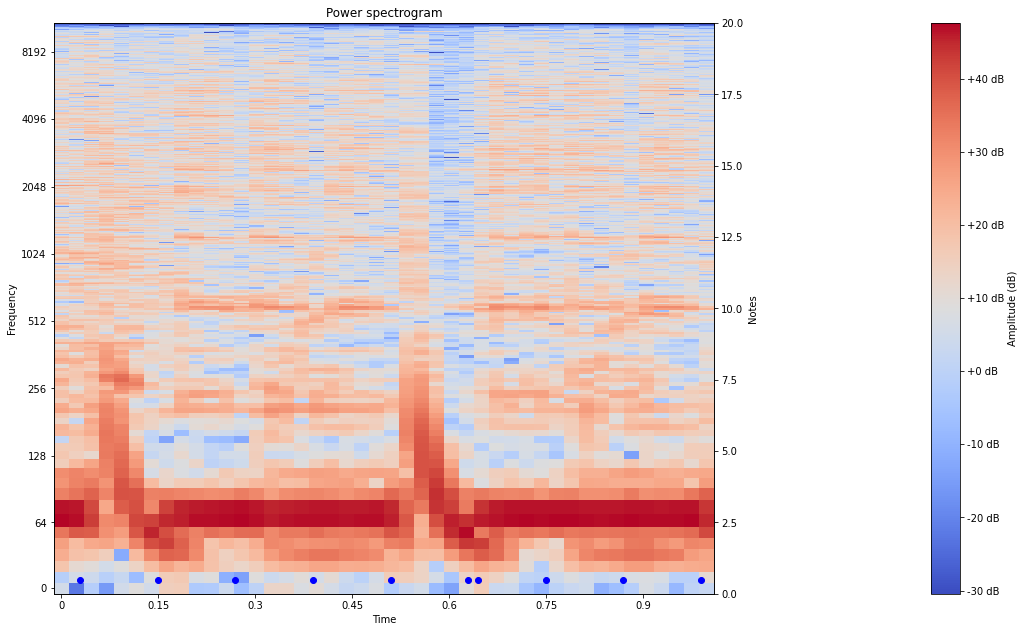

In [77]:
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots()
ax1 = ax2.twinx()
song_segment = song[:, int(3*60/segment_duration):int((3*60+1)/segment_duration)]
img = librosa.display.specshow(song_segment, y_axis='log', x_axis='time', n_fft=n_fft, hop_length=hop_length, ax=ax2)
ax2.set_ylabel('Frequency')
ax2.set_title('Power spectrogram')

# Scatter plot
points = [note.time - 3*60 for note in diffs[0].notes if note.time > 3*60 and note.time < 3*60+1]
ax1.scatter(points, [0.5 for _ in points], label='Notes', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Notes')
ax1.set_ylim(0, 20)  # Adjust the y-axis limits for the scatter plot

# Create a twin Axes sharing the xaxis

# Spectrogram

# Add colorbar
cbar = fig.colorbar(img, ax=[ax1, ax2], format="%+2.0f dB")
cbar.set_label('Amplitude (dB)')
fig.set_facecolor("w")
fig.set_size_inches(18.5, 10.5)

# fig.tight_layout()
plt.show()